# PlaygroundML
---
# 4. Support Vector Machines

In [9]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt

from svm import SupportVectorMachine
from sklearn.svm import SVC
import sklearn.datasets as datasets

Consider a dataset $\mathcal{D} = \{(\mathbf{x}_i,y_i)\}_{1\leq i \leq m} \in \mathbb{R}^n \times \{-1,1\}$ (two-class problem). A hyperplane in $\mathbb{R}^n$ is given by the following equation:
$$
    H_{\mathbf{w},b} := \{\mathbf{x} \in \mathbb{R}^n : \mathbf{w}^\top\mathbf{x} + b = 0\}
$$
and the distance from a point to a hyperplane is given by
$$
    \rho_{\mathbf{x}}(\mathbf{w},b) := \frac{|\mathbf{w}^\top\mathbf{x} + b|}{\|\mathbf{w}\|}
$$
A hyperplane is a *separating* hyperplane if $\exists \mathbf{w}\in\mathbb{R}^n$, $b\in\mathbb{R}$ such that
$$
    y_i (\mathbf{w}^\top\mathbf{x}_i + b) > 0 \quad i=1,\ldots,m
$$
The *margin* of a point $\mathbf{x}$ is defined as $\frac{\mathbf{w}^\top\mathbf{x} + b}{\|\mathbf{w}\|}$. These quantities are key for defining support vector machines (SVMs). 

## 4.1 Linearly separable data
For data that is *linearly separable*, the optimal separating canonical hyperplane is that which maximises the margin. It can be found by maximising the following objective function:
$$
    Q(\mathbf{\alpha}) = -\frac{1}{2}\mathbf{\alpha}^\top \mathbf{A} \mathbf{\alpha} + \sum_{i=1}^m \alpha_i
$$
subject to the constraints
$$
    \sum_{i=1}^m y_i \alpha_i = 0
$$
$$
    \alpha_i \geq 0
$$
where $\mathbf{\alpha}\in\mathbb{R}^m$, $A_{ij} = y_i y_j \mathbf{x}_i^\top \mathbf{x}_j$. The hyperplane parameters are then found by the following relations:
$$
    \mathbf{w} = \sum_{i=1}^m \alpha_i y_i \mathbf{x}_i
$$
$$
    b = y_j - \mathbf{w}^\top \mathbf{x}_j
$$
where $j$ denotes the index of a *support vector*, which are the vectors $\mathbf{x}_j$ corresponding to a positive component $\alpha_j > 0$.

Below we generate a dataset of two clusters using `sklearn.datasets.make_blobs()`, and plot the data.

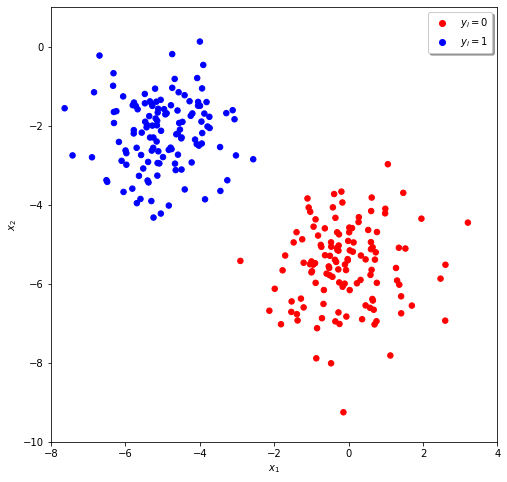

In [36]:
# Generate linearly separable data
X, y = datasets.make_blobs(n_samples=250, n_features=2, centers=2, random_state=50)
colours = ["red", "blue"]

# Plot linearly separable data
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=[colours[i] for i in y], s=30)

# Label data
plt.scatter([], [], c="red", label="$y_i=0$")
plt.scatter([], [], c="blue", label="$y_i=1$")

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-8,4)
plt.ylim(-10,1)
plt.legend(shadow=True)
plt.show()

Now we wish to train an SVM classifier and plot the optimal separating hyperplane (OSH) and margin lines. I have implemented my own code for the sake of understanding how the OSH is computed, but the classifier can be trained (more efficiently) using the `sklearn.svm.SVC` class. My classifier `SupportVectorMachine` is written up in `svm.py`, which makes use of `scipy.optimize.mimimize` for the constrained optimisation problem.

w: [-0.78128375  0.89238663], b: 1.563210820619111


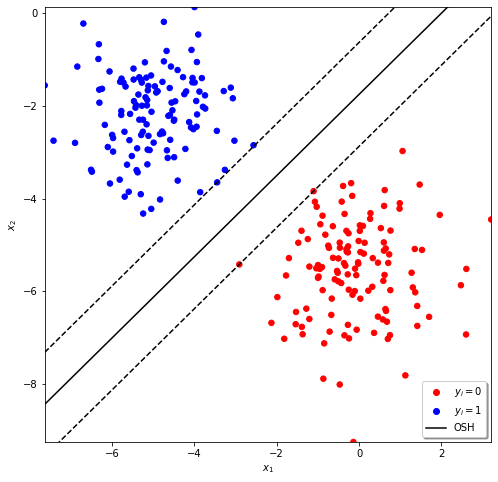

In [47]:
# Train SVM with my code
X, y = datasets.make_blobs(n_samples=250, n_features=2, centers=2, random_state=50)

# Convert labels to -1 and 1
y_relabelled = np.where(y == 0, -1, 1)

clf = SupportVectorMachine(C=1)
clf.fit(X, y_relabelled)

def plot_results(X, y, clf):
    """
    Plot results of SVM

    Args:
        X (numpy.ndarray): Input data
        y (numpy.ndarray): Labels
        clf (SupportVectorMachine): Trained SVM
    """
    # Plot results
    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0], X[:, 1], c=[colours[i] for i in y], s=30)
    plt.scatter([], [], c="red", label="$y_i=0$")
    plt.scatter([], [], c="blue", label="$y_i=1$")

    # Plot decision boundary
    w = clf.w
    b = clf.b
    print(f'w: {w}, b: {b}')
    a = -w[0] / w[1]
    xx = np.linspace(np.min(X[:,0]), np.max(X[:,0]))
    yy = a * xx - (b) / w[1]
    plt.plot(xx, yy, 'k-', label='OSH')

    # Plot margins
    margin = 1 / np.linalg.norm(w)
    yy_up = yy + np.sqrt(1 + a**2) * margin
    yy_down = yy - np.sqrt(1 + a**2) * margin
    plt.plot(xx, yy_up, 'k--')
    plt.plot(xx, yy_down, 'k--')

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(np.min(X[:,0]), np.max(X[:,0]))
    plt.ylim(np.min(X[:,1]), np.max(X[:,1]))
    plt.legend(shadow=True)
    plt.show()

plot_results(X, y, clf)

## 4.2 Linearly nonseparable data
For data which is *nonseparable*, some slight modifications are made to the OSH computation. It can be found by maximising the following objective function:
$$
    Q(\mathbf{\alpha}) = -\frac{1}{2}\mathbf{\alpha}^\top \mathbf{A} \mathbf{\alpha} + \sum_{i=1}^m \alpha_i
$$
subject to the new constraints
$$
    \sum_{i=1}^m y_i \alpha_i = 0
$$
$$
    0 \leq \alpha_i \leq C
$$
with $C\in\mathbb{R}_+$. The parameters $\mathbf{w}$ and $b$ are obtained in the same way as before. The difference now is that we have a 'box constraint' on the components $\{\alpha_i\}$. The parameter $C$ is effectively a regularising term that governs the trade-off between $\|\mathbf{w}\|^2$ and the training error from misclassifying points. An SVM on a nonseparable toy dataset is given below.

w: [0.22606964 1.20303618], b: -5.30998640088666


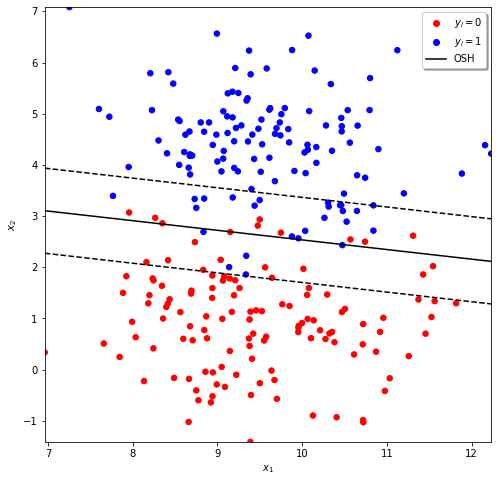

In [45]:
# Train SVM with my code
X, y = datasets.make_blobs(n_samples=250, n_features=2, centers=2, random_state=4)

# Convert labels to -1 and 1
y_relabelled = np.where(y == 0, -1, 1)

clf = SupportVectorMachine(C=0.1)
clf.fit(X, y_relabelled)

plot_results(X, y, clf)

## 4.3 SVMs with kernels

An SVM with kernel $K$ is given by the function
$$
    f(\mathbf{x}) = \sum_{i=1}^m y_i \alpha_i K(\mathbf{x}_i, \mathbf{x}) + b \qquad \mathbf{x}\in\mathbb{R}^n
$$
The components $\{\alpha_i\}$ are found with the same constrained optimisation problem above, now with $A_{ij} = y_i y_j K(\mathbf{x}_io, \mathbf{x}_j)$. A new point $\mathbf{x}\in\mathbb{R}^n$ is classified as $sgn(f(\mathbf{x}))$. It is clear to see that if $\mathbf{\phi}(\mathbf{x}) = \mathbf{x}$ (linear kernel), we recover the SVMs described in the previous sections. An implementation in `sklearn` of an SVM with a radial basis function (rbf) kernel is given below for a toy dataset of non-linear separable data.

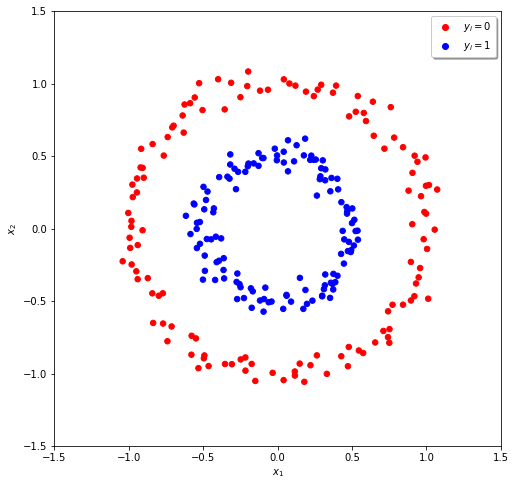

In [69]:
# Generate non-linearly separable data
X, y = datasets.make_circles(n_samples=250, noise=0.05, random_state=42, factor=0.5)

# Plot non-linearly separable data
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=[colours[i] for i in y], s=30)
plt.scatter([], [], c="red", label="$y_i=0$")
plt.scatter([], [], c="blue", label="$y_i=1$")

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend(shadow=True)
plt.show()

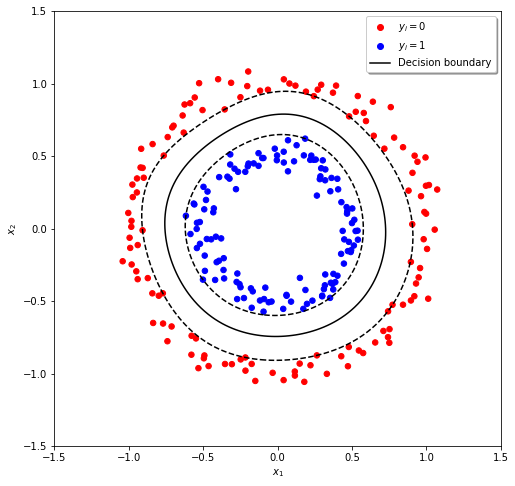

In [68]:
# Train SVM with sklearn
X, y = datasets.make_circles(n_samples=250, noise=0.05, random_state=42, factor=0.5)
clf = SVC(kernel='rbf', C=10)
clf.fit(X, y)

# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=[colours[i] for i in y], s=30)
plt.scatter([], [], c="red", label="$y_i=0$")
plt.scatter([], [], c="blue", label="$y_i=1$")

# Plot decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)

# Plot decision boundary with meshgrid
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], linestyles=['dashed', '-', 'dashed'])

# Label decision boundary
plt.plot([], [], c="black", label="Decision boundary")

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend(shadow=True)
plt.show()

## 4.4 Support vector regression (SVR)